In [99]:
import numpy as np
import pandas as pd
from matplotlib import pylab as plt

In [100]:
data = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

Т.к. мы хотим использовать линейную регрессию, попытаемся представить все признаки в виде чисел. Прежде всего отрешемся от бренной сущности праздников, преобразовав этот признак в бинарный (т.е. нас будет интересовать лишь наличие праздника, а не его конкретное название).

In [101]:
def convert_holiday(x):
    if x == 'None':
        return 0
    return 1

data.holiday = [convert_holiday(x) for x in data.holiday]

In [103]:
weather_types = set(data.weather_main)
print(weather_types)

{'Rain', 'Thunderstorm', 'Fog', 'Clouds', 'Clear', 'Squall', 'Smoke', 'Haze', 'Mist', 'Drizzle', 'Snow'}


In [104]:
weather_to_num = dict()
weather_to_num['Clear'] = 0
weather_to_num['Clouds'] = 1
weather_to_num['Mist'] = 1
weather_to_num['Smoke'] = 1
weather_to_num['Haze'] = 1
weather_to_num['Fog'] = 2
weather_to_num['Snow'] = 2
weather_to_num['Drizzle'] = 2
weather_to_num['Rain'] = 3
weather_to_num['Thunderstorm'] = 4
weather_to_num['Squall'] = 5

data.weather_main = [weather_to_num[x] for x in data.weather_main]
data = data.drop('weather_description', axis = 1)

In [105]:
data.head(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
0,0,288.28,0.0,0.0,40,1,2012-10-02 09:00:00,5545
1,0,289.36,0.0,0.0,75,1,2012-10-02 10:00:00,4516
2,0,289.58,0.0,0.0,90,1,2012-10-02 11:00:00,4767
3,0,290.13,0.0,0.0,90,1,2012-10-02 12:00:00,5026
4,0,291.14,0.0,0.0,75,1,2012-10-02 13:00:00,4918
5,0,291.72,0.0,0.0,1,0,2012-10-02 14:00:00,5181
6,0,293.17,0.0,0.0,1,0,2012-10-02 15:00:00,5584
7,0,293.86,0.0,0.0,1,0,2012-10-02 16:00:00,6015
8,0,294.14,0.0,0.0,20,1,2012-10-02 17:00:00,5791
9,0,293.10,0.0,0.0,20,1,2012-10-02 18:00:00,4770


In [106]:
def datetime_hour(s):
    x = s.split(' ')
    y = x[1].split(':')
    return int(y[0])

def datetime_month(s):
    x = s.split(' ')
    y = x[0].split('-')
    return int(y[1])


data['month'] = [datetime_month(x) for x in data.date_time]
data['hour'] = [datetime_hour(x) for x in data.date_time]
data = data.drop('date_time', axis = 1)
data.head(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,traffic_volume,month,hour
0,0,288.28,0.0,0.0,40,1,5545,10,9
1,0,289.36,0.0,0.0,75,1,4516,10,10
2,0,289.58,0.0,0.0,90,1,4767,10,11
3,0,290.13,0.0,0.0,90,1,5026,10,12
4,0,291.14,0.0,0.0,75,1,4918,10,13
5,0,291.72,0.0,0.0,1,0,5181,10,14
6,0,293.17,0.0,0.0,1,0,5584,10,15
7,0,293.86,0.0,0.0,1,0,6015,10,16
8,0,294.14,0.0,0.0,20,1,5791,10,17
9,0,293.10,0.0,0.0,20,1,4770,10,18


Итак, мы несколько огрубили нашу изначальную модель, будем надеяться, что ничего плохого не случится (в любом случае самостоятельно повторять не рекомендуется). Продолжим.

In [107]:
X = data.drop('traffic_volume', axis = 1).to_numpy()

In [109]:
y = data.traffic_volume.to_numpy()

In [110]:
means = X.mean(axis = 0)
stds = X.std(axis = 0)
X = np.array([(np.array(x) - means)/stds for x in X])

In [111]:
X = np.append(np.append(X, X**2, axis = 1), np.sin(X), axis = 1)

Признаки отнормированы, пока всё хорошо. Но не слишком ли их много? Например, есть подозрение, что month, hour и temp довольно сильно взаимосвязаны и какой-то из них можно выкинуть.

In [112]:
print(len(X))

48204


Как видим, объектов много. Поэтому сделаем максимально тупо: разобьем выборку на обучающую и тестовую случайным образом, надеясь, что при таких объемах мы не получим плохого (концентрированного) разбиения.

In [113]:
train_ids = np.random.choice(len(X), int(len(X)*0.7), replace = False)
control_ids = set(np.arange(len(X))) - set(train_ids)
X_train = np.array([X[i] for i in train_ids])
y_train = np.array([y[i] for i in train_ids])
X_control = np.array([X[i] for i in control_ids])
y_control = np.array([y[i] for i in control_ids])

Давайте попробуем реализовать add-del алгоритм.

In [114]:
def mserror(y, y_pred):
    return np.mean((y - y_pred)**2)

def add_ones(X):
    #print type(X)
    return np.append(X, np.ones((np.size(X, axis = 0), 1)), axis = 1)

def add_del(X_train, y_train, X_control, y_control, steps_after_best = 4, do_all_iterations = False):
    global Y
    selected_ids = set()
    remained_ids = set(np.arange(np.size(X_train, axis = 1)))
    iteration = 0
    best_res = np.inf
    best_res_it = 0
    best_ids = set()
    while True:
        iteration += 1
        if len(remained_ids) == 0:
            return selected_ids
        if not do_all_iterations:
            if iteration - best_res_it == steps_after_best:
                return best_ids
        if iteration%3 != 0:
            min_id = -1
            min_err = np.inf
            for i in remained_ids:
                selected_ids.add(i)
                new_X_train = X_train[:, list(selected_ids)]
                new_X_control = X_control[:, list(selected_ids)]
                selected_ids.remove(i)
                new_X_train = add_ones(new_X_train)
                new_X_control = add_ones(new_X_control)
                w = np.dot(np.linalg.pinv(new_X_train), y_train)
                err = mserror(y_control, np.dot(new_X_control, w))
                if err < min_err:
                    min_err = err
                    min_id = i
            selected_ids.add(min_id)
            remained_ids.remove(min_id)
            if best_res > min_err:
                best_res_it = iteration
                best_res = min_err
                best_ids = selected_ids
            Y.append(min_err)
        else:
            min_id = -1
            min_err = np.inf
            for i in selected_ids:
                selected_ids.remove(i)
                new_X_train = X_train[:, list(selected_ids)]
                new_X_control = X_control[:, list(selected_ids)]
                selected_ids.add(i)
                new_X_train = add_ones(new_X_train)
                new_X_control = add_ones(new_X_control)
                w = np.dot(np.linalg.pinv(new_X_train), y_train)
                err = mserror(y_control, np.dot(new_X_control, w))
                if err < min_err:
                    min_err = err
                    min_id = i
            remained_ids.add(min_id)
            selected_ids.remove(min_id)
            
            if best_res > min_err:
                best_res_it = iteration
                best_res = min_err
                best_ids = selected_ids
            Y.append(min_err)
                

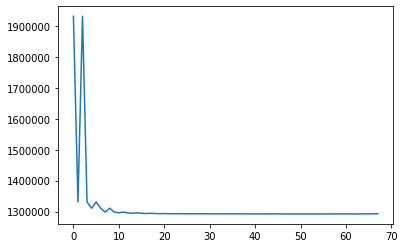

In [115]:
Y = []
add_del(X_train, y_train, X_control, y_control, do_all_iterations=True)
plt.plot(range(len(Y)), Y)

Как видим, примерно после десятой итерации улучшений почти нет. Тем не менее, если запустить алгоритм, убрав флаг do_all_iterations, то можно заметить, что добавление новых признаков все равно продолжает улучшать результат на тестовой (!) выборке, т.е. переобучения никакого не наблюдается и все очень даже хорошо.

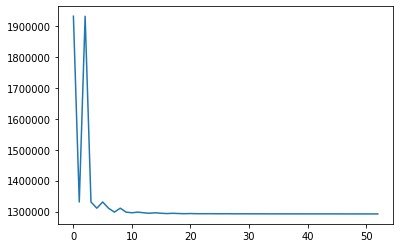

In [116]:
Y = []
add_del(X_train, y_train, X_control, y_control)
plt.plot(range(len(Y)), Y)

Алгоритм проделал чуть более 50 итераций. Это меньше, чем в прошлый раз. Т.е. с этого момента результаты перестали улучшаться от слова совсем. На самом деле они практически перестали улучшаться на 10-й итерации (но всё же продолжали!)

Возможно, в дальнейшем имеет смысл установить некоторое эпсилон, так что если ошибка уменьшается меньше, чем на это эпсилон, то отбор признаков уменьшается, потому что такое незначительное улучшение не стоит вычислительных затрат (чем больше признаков, тем большие матрицы нам нужно будет перемножать). Но с точки зрения самой ф-ции отбора ошибок в этом большого смысла нет, ведь хоть и медленно, но рез-ты продолжают улучшаться. Тут всё зависит уже от того, за чем вы гонитесь: за скоростью работы или за точностью?